<a href="https://colab.research.google.com/github/Eitan177/EitanAmrom/blob/main/variantfile_annotated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the variants in the maf and mastervariant text files to generate cosmic/clinvar/gnomad/oncokb/perplexity annotated variant files

This Python script processes a MAF (Mutation Annotation Format) file to filter variants based on specific criteria and then generates a boxplot of the 't_AF' (tumor allele frequency) column.
1. **Import Libraries:**
   - `pandas` for data manipulation.
   - `glob` for file path matching.
   - `matplotlib.pyplot` for plotting.

2. **Read the MAF File:**
   - `df = pd.read_csv(glob.glob('*.final.smallvariants.maf')[0], sep='\t', skiprows=1)`: Reads the first MAF file found in the current directory that ends with '.final.smallvariants.maf'.

3. **Initial Filtering:**
   - `filtered_df = df[...]`: Filters the DataFrame based on these criteria:
     - `(df['t_depth'] >= 150)`: Tumor depth must be greater than or equal to 150.
     - `(df['t_alt_count'] >= 20)`: Tumor alternate allele count must be greater than or equal to 20.
   - This filters out variants with low coverage or low alternate allele counts.

4. **Identify Allele Frequency Columns:**
   - `af_columns = [...]`: Creates a list of column names that end with '_AF' but excludes the 't_AF' column.  These are allele frequencies from the gnomad database.

5. **Further Filtering based on Allele Frequencies:**
   - `filtered_df = filtered_df[...]`: Filters the DataFrame further. It checks each row, using the columns in `af_columns`, to ensure that all allele frequencies are less than 0.0005 or NaN (Not a Number).  This helps eliminate common variants.

6. **'t_AF' Column Processing:**
   - The code checks if a column named 't_AF' exists in `filtered_df`.
   - It then attempts to convert the column's values to numeric.
   - If non-numeric values are encountered, an error is caught and the values are coerced to NaN (using `pd.to_numeric(..., errors='coerce')`). Rows with NaN values in the 't_AF' column are dropped (using `dropna()`).
   - If the column exists and has only valid numeric data, a boxplot of the 't_AF' values is created and displayed along with the raw data points.  A `ValueError` occurs if this conversion is not successful, meaning that some values in the series are not numeric. This check ensures that the subsequent boxplot creation won't fail due to non-numeric data.

7. **Boxplot Generation (Conditional):**
   - If the 't_AF' column exists and is successfully converted to numeric, it creates a boxplot of the values using `matplotlib.pyplot`.

t_AF column exists.
object
16    0.145
18    0.062
21    0.021
52     0.11
53      NaN
Name: t_AF, dtype: object
Non numeric values found in t_AF
Unable to parse string "0.006091,0.031,0.093,0.376,0.099,0.323,0.019" at position 7


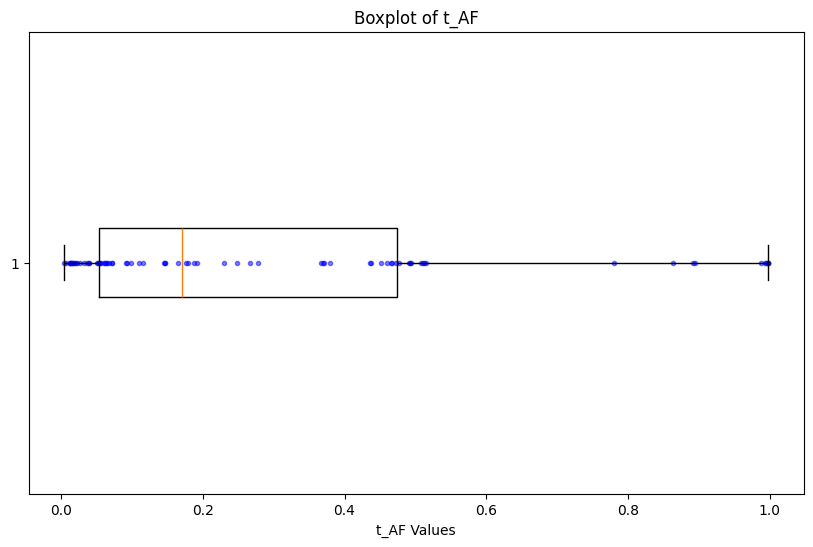

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Read the data, skip the first line
df = pd.read_csv(glob.glob('*.final.smallvariants.maf')[0], sep='\t', skiprows=1)

# Filter the DataFrame based on the specified criteria
# use isin instead of in for filtering series against a list.
filtered_df = df[
    #(df['Reference_Allele'].isin(['A','G','T','C'])) &
    #(df['Tumor_Seq_Allele2'].isin(['A','G','T','C'])) &
    (df['t_depth'] >= 150) &
    (df['t_alt_count'] >= 20)
]

af_columns = [col for col in filtered_df.columns if col.endswith('_AF') and col != 't_AF']

# Convert all values in af_columns to numeric, coercing errors to NaN
#for col in af_columns:
#    filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce')

# Filter rows based on the criteria
filtered_df = filtered_df[
    filtered_df[af_columns].apply(lambda row: all(x < 0.0005 or pd.isna(x) for x in row), axis=1)
]


# remove rows starting with 'rs' in the dbSNP_RS column.
# convert dbSNP_RS to string before removing rows
filtered_df['dbSNP_RS'] = filtered_df['dbSNP_RS'].astype(str)

# Check if the 't_AF' column exists and print its data types
if 't_AF' in filtered_df.columns:
    print("t_AF column exists.")
    print(filtered_df['t_AF'].dtype)
    print(filtered_df['t_AF'].head())
    # Check to see if the values of the column are numeric.
    try:
      pd.to_numeric(filtered_df['t_AF'])
      print('All values in t_AF are numeric')
    except ValueError as err:
      print('Non numeric values found in t_AF')
      print(err)
    filtered_df['t_AF'] = pd.to_numeric(filtered_df['t_AF'], errors='coerce')

    # Drop rows where 't_AF' is NaN (indicating non-numeric values)
    filtered_df = filtered_df.dropna(subset=['t_AF'])
    # If it exists, create the boxplot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.boxplot(filtered_df['t_AF'], vert=False)  # vert=False to make horizontal
    plt.scatter(filtered_df['t_AF'], [1] * len(filtered_df['t_AF']), marker='.', color='blue', alpha=0.5) # Adjust alpha for visibility

    plt.xlabel('t_AF Values')
    plt.title('Boxplot of t_AF')
    plt.show()
else:
    print("t_AF column does not exist in filtered_df.")

** Merging with Master Variant Table:**

- Reads a master variant table (likely containing additional annotations) into a DataFrame.
- Merges this master table with the filtered MAF data based on chromosome and start position. This adds annotations from the master table to the filtered variant data.


In [ ]:
import glob
import pandas as pd
# Find the file ending with "MasterVariantTableXtreme.txt"
master_variant_file = glob.glob('*MasterVariantTableXtreme.txt')[0]

# Read the master variant table into a DataFrame
masterdf = pd.read_csv(master_variant_file, sep='\t')

# Merge the two dataframes
merged_df = pd.merge(filtered_df, masterdf,  how='left', left_on=["Chromosome", "Start_Position"],right_on=['CHROM', 'POS'])#, "Reference_Allele", "Tumor_Seq_Allele2"], right_on=['CHROM', 'POS', 'REF', 'ALT'])

# Display the merged dataframe (optional)
merged_df



**Link Generation:**

-  **`create_oncokb_link(row)`:** This function constructs links to the OncoKB database.
    - It checks if the `GENE` and `p.CHANGE` fields are not NaN.
    -  If both are valid, it returns a URL formatted as: `https://www.oncokb.org/gene/<GENE>/<p.CHANGE>`
    - If either field is missing, it returns `None`.

-  **`create_cosmic_link(row)`:** This function generates links to the COSMIC (Catalogue of Somatic Mutations in Cancer) database.
    - It extracts the start position of the mutation from the `p.CHANGE` column using regular expressions. If there's an error or no number is found, it sets `start_pos` to 0.
    - It builds a URL that queries COSMIC around that start position, with a fixed window size of 10 base pairs. The URL includes additional parameters, including the gene name.

- **ClinVar, gnomAD Links:** These functions are simpler string concatenations, generating direct URLs to ClinVar and gnomAD using the data present in the merged dataframe.

**Adding Links to DataFrame:**

The generated links are added to the `merged_df` as new columns:

- `clinvar_link`: ClinVar link based on GENE and c.CHANGE.
- `cosmic_link`: COSMIC link created using `create_cosmic_link`.
- `oncokb_link`: OncoKB link created using `create_oncokb_link`.
- `gnomad_link`: gnomAD link based on chromosome and start position.

In [ ]:
import re
import pandas as pd

def create_oncokb_link(row):
  if pd.isna(row[0]) or pd.isna(row[1]): # Use pd.isna to check for NaN
    return None
  else:
    print(row)
    return 'https://www.oncokb.org/gene/' + row.iloc[0] + '/' + row.iloc[1]

def create_cosmic_link(row):
    try:
        p_change = row['p.CHANGE']
        if pd.isna(p_change):
            start_pos = 0
        else:
            match = re.search(r'(\d+)', p_change)  # Find the number in p.CHANGE
            if match:
                start_pos = int(match.group(1))
            else:
                start_pos = 0
    except (ValueError, TypeError):
        start_pos = 0
    return 'https://cancer.sanger.ac.uk/cosmic/gene/analysis?coords=AA%3AAA&end=' + str(start_pos + 10) + '&genome=hg38&id=2&ln=' + str(row['GENE']) + '&start=' + str(start_pos) + '&wgs=off'

merged_df['clinvar_link'] = 'https://www.ncbi.nlm.nih.gov/clinvar/?term='+merged_df['GENE']+'+'+merged_df['c.CHANGE']
merged_df['cosmic_link'] = merged_df.apply(create_cosmic_link, axis=1)
merged_df['oncokb_link'] = merged_df[['GENE','p.CHANGE']].apply(create_oncokb_link,axis=1)
merged_df['gnomad_link'] = 'https://gnomad.broadinstitute.org/region/' +merged_df['Chromosome'].astype(str) + '-' + merged_df['Start_Position'].astype(str)


GENE            SPEN
p.CHANGE    p.P3247=
Name: 0, dtype: object
GENE            SPEN
p.CHANGE    p.A3248P
Name: 1, dtype: object
GENE            SPEN
p.CHANGE    p.V3250L
Name: 2, dtype: object
GENE            SPEN
p.CHANGE    p.V3250P
Name: 3, dtype: object
GENE              SPEN
p.CHANGE    p.V3252del
Name: 4, dtype: object
GENE        NOTCH2
p.CHANGE     p.M1?
Name: 5, dtype: object
GENE                 ALK
p.CHANGE    p.F921Wfs*26
Name: 10, dtype: object
GENE           PDK1
p.CHANGE    p.R203*
Name: 14, dtype: object
GENE          GATA2
p.CHANGE    p.T176=
Name: 15, dtype: object
GENE          SLIT2
p.CHANGE    p.R812H
Name: 17, dtype: object
GENE         RICTOR
p.CHANGE    p.R241=
Name: 18, dtype: object
GENE          CSF1R
p.CHANGE    p.V116=
Name: 19, dtype: object
GENE        HIST1H1C
p.CHANGE     p.K191=
Name: 20, dtype: object
GENE         HLA-A
p.CHANGE    p.F33I
Name: 21, dtype: object
GENE         HLA-A
p.CHANGE    p.F33T
Name: 22, dtype: object
GENE          HLA-A
p.CHAN

<ipython-input-4-3c8583d2aa1f>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(row[0]) or pd.isna(row[1]): # Use pd.isna to check for NaN


**HTML Table Generation:**
   - Generates an HTML file (`mutation_table.html`) containing a table of the processed variants.  
   - The HTML includes a column for action buttons with javascript functionality:
      - "Open All Links": Opens all links for a row in new browser tabs.
      - "Ask Perplexity": Opens a Perplexity.ai search with the GENE and p.CHANGE as a query.
      - "Show/Hide Links": Toggles the display of a hidden list of the relevant links for each row.
   - Columns with data relevant to the variants are included.  The html also styles specific rows that pass a filter.

**Downloading the HTML File:**
   - Provides an option to download the generated HTML file using `files.download`.

In [ ]:
import pandas as pd
import re

df=merged_df.copy()
def extract_gene_protein(link):
    if not isinstance(link, str):
        return None, None

    # Updated pattern to match oncokb links without 'alteration/'
    # Assuming the pattern is something like 'gene/BRAF/V600E'
    match = re.search(r'/gene/([^/]+)/([^/]+)', link)
    if match:
        gene = match.group(1)
        protein_change = match.group(2)
        return gene, protein_change
    return None, None

# Sort the dataframe - first by FILTER_x (PASS at top), then by AF_y descending
if 'FILTER_x' in df.columns and 'Variant_Classification' in df.columns and 'AF_y' in df.columns:
    # Create a temporary column for sorting FILTER_x (PASS first)
    df['sort_filter'] = df['FILTER_x'].apply(lambda x: 0 if x == 'PASS' else 1)
    df['sort_filter1']=df['Variant_Classification'].apply(lambda x: 0 if x == 'Missense_Mutation' else 1)
    # Sort by the temporary column, then by AF_y descending
    df = df.sort_values(by=['sort_filter','sort_filter1', 'AF_y'], ascending=[True,True, False])
    # Drop the temporary column
    df = df.drop(columns=['sort_filter','sort_filter1'])

# Create HTML content with links on the left
html_content = """
<!DOCTYPE html>
<html>
<head>
    <title>Mutation Data Table</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; }
        table { width: 100%; border-collapse: collapse; margin-bottom: 20px; }
        th { background-color: #f2f2f2; padding: 8px; text-align: left; border: 1px solid #ddd; position: sticky; top: 0; }
        td { padding: 8px; border: 1px solid #ddd; vertical-align: top; }
        .action-cell { width: 250px; }
        button { padding: 6px 10px; margin: 3px; border: none; cursor: pointer; display: block; width: 100%; }
        .links-btn { background: #4CAF50; color: white; }
        .perplexity-btn { background: #6B4DE6; color: white; }
        .toggle-btn { background: #2196F3; color: white; }
        .links-container { display: none; margin-top: 5px; }
        a { display: block; margin: 5px 0; color: #2196F3; text-decoration: none; }
        a:hover { text-decoration: underline; }
        h2 { margin-bottom: 20px; }
        .pass { background-color: #e8f5e9; } /* Light green background for PASS rows */
    </style>
</head>
<body>
    <h2>Mutation Data and Links</h2>
    <table>
        <thead>
            <tr>
                <th class="action-cell">Actions</th>
"""

# Target columns for links
link_columns = ['clinvar_link', 'gnomad_link', 'oncokb_link', 'cosmic_link']

# Additional data columns to display
data_columns = ['GENE','p.CHANGE','AF_y', 'ClinVar', 'FILTER_x','CHROM','Start_Position', 'End_Position', 'Reference_Allele',
               'Tumor_Seq_Allele2' , 'c.CHANGE',
               'Variant_Classification', 'dbSNP_RS', 't_depth', 't_ref_count',
               't_alt_count',]

# Add table headers for data columns
for column in data_columns:
    if column in df.columns:
        html_content += f"<th>{column}</th>\n"

html_content += """
            </tr>
        </thead>
        <tbody>
"""

# Add each row of data
for index, row in df.iterrows():
    row_links = []
    oncokb_link = None
    gene = None
    protein_change = None

    # Collect links
    for column in link_columns:
        if column in df.columns and pd.notna(row.get(column)):
            row_links.append((column, row[column]))
            if column == 'oncokb_link':
                oncokb_link = row[column]
                gene, protein_change = extract_gene_protein(oncokb_link)

    # Determine if this row is a PASS row for styling
    is_pass = 'FILTER_x' in df.columns and row.get('FILTER_x') == 'PASS'
    is_missense = 'Variant_Classification' in df.columns and row.get('Variant_Classification') == 'Missense_Mutation'
    row_class = ' class="pass"' if is_pass else ''

    # Create table row
    html_content += f"<tr{row_class}>\n"

    # Create a unique ID for this row's links
    row_id = f"row_{index}"

    # Add action cell with buttons (now on the left)
    html_content += f"""
        <td class="action-cell">
            <button class="links-btn" onclick="openRowLinks('{row_id}')">Open All Links</button>
    """

    # Add Perplexity button if gene and protein were extracted
    if gene and protein_change:
        perplexity_url = f"https://www.perplexity.ai/search?q=Tell+me+about+the+{gene}+{protein_change}+mutation+in+cancer+and+its+clinical+implications"
        html_content += f"""
            <button class="perplexity-btn" onclick="window.open('{perplexity_url}', '_blank')">Ask Perplexity</button>
        """

    html_content += f"""
            <button class="toggle-btn" onclick="toggleLinks('{row_id}')">Show/Hide Links</button>
            <div id="{row_id}" class="links-container">
    """

    # Add links
    for link_label, link in row_links:
        display_label = link_label.replace('_link', '').capitalize()
        html_content += f'<a href="{link}" target="_blank">{display_label}</a>\n'

    # Close action cell
    html_content += """
            </div>
        </td>
    """

    # Add data cells
    for column in data_columns:
        if column in df.columns:
            value = row.get(column, "")
            if pd.isna(value):
                value = ""
            html_content += f"<td>{value}</td>\n"

    # Close row
    html_content += "</tr>\n"

# Close table and add JavaScript
html_content += """
        </tbody>
    </table>

    <script>
    function openRowLinks(rowId) {
        const linkContainer = document.getElementById(rowId);
        const links = linkContainer.getElementsByTagName('a');
        for (let i = 0; i < links.length; i++) {
            window.open(links[i].href, '_blank');
        }
    }

    function toggleLinks(rowId) {
        const linkContainer = document.getElementById(rowId);
        if (linkContainer.style.display === 'block') {
            linkContainer.style.display = 'none';
        } else {
            linkContainer.style.display = 'block';
        }
    }
    </script>
</body>
</html>
"""

# Write HTML to a file
with open('mutation_table.html', 'w') as f:
    f.write(html_content)

# You can download the file from Colab if needed
from google.colab import files
files.download('mutation_table.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>